In [1]:
import pandas as pd
# 저희는 Tabular Data를 다루기 때문에 아래 라이브러리를 호출합니다.
from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [2]:
def winsor_from_train(train, test, cols, low=0.01, high=0.99):
    train = train.copy()
    test = test.copy()
    for col in cols:
        lo, hi = train[col].quantile([low, high])
        train[col] = train[col].clip(lo, hi)
        test[col] = test[col].clip(lo, hi)
    return train, test


cols_to_winsor = ["중성 지방","혈청 크레아티닌","저밀도지단백","간 효소율","콜레스테롤", "공복 혈당"]

train_df, test_df = winsor_from_train(train_df, test_df, cols_to_winsor, low=0.01, high=0.99)

In [3]:
def bmi_cat(df):
    df.loc[df['BMI'] < 18.5, 'BMI_cat'] = '저체중'
    df.loc[(df['BMI'] >= 18.5) & (df['BMI'] < 23), 'BMI_cat'] = '정상'
    df.loc[(df['BMI'] >= 23) & (df['BMI'] < 25), 'BMI_cat'] = '비만 전 단계'
    df.loc[(df['BMI'] >= 25) & (df['BMI'] < 30), 'BMI_cat'] = '1단계 비만'
    df.loc[(df['BMI'] >= 30) & (df['BMI'] < 35), 'BMI_cat'] = '2단계 비만'
    df.loc[df['BMI'] >= 35, 'BMI_cat'] = '3단계 비만'

    df['BMI_cat'] = df['BMI_cat'].astype('category')
    return df

def fat_cat(df):
    df.loc[df['중성 지방'] < 150, '지방_cat'] = '정상'
    df.loc[(df['중성 지방'] >= 150) & (df['중성 지방'] < 200), '지방_cat'] = '경계'
    df.loc[df['중성 지방'] >= 200, '지방_cat'] = '위험'

    df['지방_cat'] = df['지방_cat'].astype('category')
    return df

def choles_cat(df):
    df.loc[df['콜레스테롤'] < 200, '콜레스테롤_cat'] = '정상'
    df.loc[(df['콜레스테롤'] >= 200) & (df['콜레스테롤'] < 240), '콜레스테롤_cat'] = '경계'
    df.loc[df['콜레스테롤'] >= 240, '콜레스테롤_cat'] = '위험'

    df['콜레스테롤_cat'] = df['콜레스테롤_cat'].astype('category')
    return df

def ldl_cat(df):
    df.loc[df['저밀도지단백'] < 100, 'ldl_cat'] = '정상'
    df.loc[(df['저밀도지단백'] >= 100) & (df['저밀도지단백'] < 130), 'ldl_cat'] = '거의 정상'
    df.loc[(df['저밀도지단백'] >= 130) & (df['저밀도지단백'] < 160), 'ldl_cat'] = '경계'
    df.loc[(df['저밀도지단백'] >= 160) & (df['저밀도지단백'] < 190), 'ldl_cat'] = '위험'
    df.loc[df['저밀도지단백'] >= 190, 'ldl_cat'] = '매우 위험'

    df['ldl_cat'] = df['ldl_cat'].astype('category')
    return df

def hdl_cat(df):
    df.loc[df['고밀도지단백'] < 40, 'hdl_cat'] = '위험'
    df.loc[(df['고밀도지단백'] >= 40) & (df['고밀도지단백'] < 60), 'hdl_cat'] = '경계'
    df.loc[df['고밀도지단백'] >= 60, 'hdl_cat'] = '정상'

    df['hdl_cat'] = df['hdl_cat'].astype('category')
    return df


def make_age_cat(df):
    bins   = [0, 29, 39, 49, 59, 69, 150]
    labels = ["20-29","30-39","40-49","50-59","60-69","70+"]
    df["age_cat"] = pd.cut(df["나이"], bins=bins, labels=labels)
    df["age_cat"] = df["age_cat"].astype("category")
    return df

# def add_lipid_features(df):
#     TG = "중성 지방"
#     HDL = "고밀도지단백"
#     LDL = "저밀도지단백"
#     TC = "콜레스테롤"

#     eps = 1e-6

#     df["TG_HDL"]  = df[TG] / (df[HDL] + eps)
#     df["LDL_HDL"] = df[LDL] / (df[HDL] + eps)
#     df["Non_HDL"] = df[TC] - df[HDL]
#     df["AIP"]     = np.log10(df[TG] / (df[HDL] + eps))

#     return df

# def add_hb_cr_bmi(df):
#     Hb = "헤모글로빈"
#     Cr = "혈청 크레아티닌"
#     eps = 1e-6

#     if "BMI" not in df.columns:
#         df["BMI"] = df["몸무게(kg)"] / ((df["키(cm)"] / 100) ** 2)

#     df["Hb_Cr"] = df[Hb] / (df[Cr] + eps)
#     return df

# def add_age_interactions(df):
#     if "TG_HDL" in df.columns:
#         df["age_TG_HDL"] = df["나이"] * df["TG_HDL"]
#     if "Hb_Cr" in df.columns:
#         df["age_Hb_Cr"]  = df["나이"] * df["Hb_Cr"]
#     return df


# def add_features(df):
#     # 순서대로 다 돌린다
#     df = bmi_cat(df)
#     df = fat_cat(df)
#     df = choles_cat(df)
#     df = ldl_cat(df)
#     df = hdl_cat(df)
#     df = make_age_cat(df)
#     eps = 1e-6

#     # 1) Lipid ratios
#     df['hdl_ldl_ratio']  = df['고밀도지단백'] / (df['저밀도지단백'] + eps)
#     df['tg_hdl_ratio']   = df['중성 지방']   / (df['고밀도지단백'] + eps)
#     df['chol_hdl_ratio'] = df['콜레스테롤']  / (df['고밀도지단백'] + eps)

#     # 2) Liver / glucose interactions
#     df['bmi_liver_interact']  = df['BMI'] * df['간 효소율']
#     df['blood_glucose_liver'] = df['공복 혈당'] * df['간 효소율']

#     # 3) Body composition + age / BP
#     df['bmi_age'] = df['BMI'] * df['나이']
#     df['bp_bmi']  = df['혈압'] * df['BMI']

#     # 4) Kidney + size
#     df['creatinine_bmi'] = df['혈청 크레아티닌'] * df['BMI']

#     # 5) Synergy interactions
#     df['glucose_bmi_interact'] = df['공복 혈당'] * df['BMI']
#     df['tg_bp_interact']       = df['중성 지방'] * df['혈압']

#     # 6) Log transforms
#     df['log_tg']      = np.log1p(df['중성 지방'])
#     df['log_chol']    = np.log1p(df['콜레스테롤'])
#     df['log_glucose'] = np.log1p(df['공복 혈당'])
    
#     # df = add_lipid_features(df)
#     # df = add_hb_cr_bmi(df)
#     #df = add_age_interactions(df)
#     return df

def add_features(df):
    df = bmi_cat(df)
    df = fat_cat(df)
    df = choles_cat(df)
    df = ldl_cat(df)
    df = hdl_cat(df)
    df = make_age_cat(df)

    eps = 1e-6

    # 필수 · strong signal
    df['tg_hdl_ratio'] = df['중성 지방'] / (df['고밀도지단백'] + eps)
    df['hdl_ldl_ratio'] = df['고밀도지단백'] / (df['저밀도지단백'] + eps)
    df['chol_hdl_ratio'] = df['콜레스테롤'] / (df['고밀도지단백'] + eps)

    df['glucose_bmi_interact'] = df['공복 혈당'] * df['BMI']
    df['log_tg'] = np.log1p(df['중성 지방'])
    df['log_glucose'] = np.log1p(df['공복 혈당'])

    # optional (넣어도 안정적)
    df['bmi_liver_interact'] = df['BMI'] * df['간 효소율']
    df['blood_glucose_liver'] = df['공복 혈당'] * df['간 효소율']
    df['creatinine_age'] = df['혈청 크레아티닌'] * df['나이']

    return df


In [4]:
train_df = add_features(train_df)
test_df = add_features(test_df)

train = TabularDataset(train_df.drop(['ID'], axis=1))
test = TabularDataset(test_df.drop(['ID'], axis=1))

train_data = TabularDataset(train_df)

In [5]:
predictor_ = TabularPredictor(
    label='label',
    #path=save_path,
    eval_metric='accuracy',
    problem_type='binary'
)

predictor_.fit(
    train_data=train_data,
    presets='medium_quality_faster_train',
    time_limit=60 * 5,
    # num_gpus=1,
    # auto_stack=True,
    num_stack_levels=1,
    num_bag_folds=5, 
    # num_bag_sets=2,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251127_081529"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:49 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T6000
CPU Count:          10
Memory Avail:       5.64 GB / 16.00 GB (35.2%)
Disk Space Avail:   388.07 GB / 460.43 GB (84.3%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/admin/Downloads/미니프로젝트(흡연)/AutogluonModels/ag-20251127_081529"
Train Data Rows:    7000
Train Data Columns: 32
Label Column:       label
Problem Type:       binary
Preprocessing data ...
Selected cl

KeyboardInterrupt: 

In [6]:
ld_board = predictor_.leaderboard(train, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestGini_BAG_L1,1.000000,0.733571,accuracy,0.085460,0.163987,0.719496,0.085460,0.163987,0.719496,1,True,3
1,RandomForestEntr_BAG_L1,1.000000,0.731857,accuracy,0.090059,0.177664,0.827400,0.090059,0.177664,0.827400,1,True,4
2,ExtraTreesGini_BAG_L1,1.000000,0.726714,accuracy,0.100343,0.178157,0.368340,0.100343,0.178157,0.368340,1,True,6
3,ExtraTreesEntr_BAG_L1,1.000000,0.728143,accuracy,0.116005,0.177458,0.381830,0.116005,0.177458,0.381830,1,True,7
4,RandomForestGini_BAG_L2,1.000000,0.741857,accuracy,1.508502,1.111216,166.782216,0.071843,0.160801,0.832822,2,True,15
5,RandomForestEntr_BAG_L2,0.999714,0.739429,accuracy,1.514764,1.112503,166.869177,0.078105,0.162088,0.919783,2,True,16
6,ExtraTreesGini_BAG_L2,0.999714,0.742571,accuracy,1.534328,1.126226,166.329755,0.097670,0.175811,0.380361,2,True,18
7,NeuralNetFastAI_BAG_L2,0.999714,0.743714,accuracy,1.741608,1.019298,187.944887,0.304950,0.068883,21.995493,2,True,20
8,CatBoost_BAG_L2,0.999429,0.748429,accuracy,1.454539,0.960340,175.529703,0.017881,0.009925,9.580309,2,True,17
9,ExtraTreesEntr_BAG_L2,0.999000,0.739143,accuracy,1.545934,1.126612,166.329587,0.109276,0.176197,0.380193,2,True,19


In [8]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# 1) X, y 분리 (이미 train_df 쓰고 있다고 가정)
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']   # 0 = 비흡연, 1 = 흡연

# 2) 훈련 데이터에 대한 예측 확률 / 예측 클래스
proba_train = predictor_.predict_proba(X_train, as_multiclass=False)  # 클래스1(흡연자) 확률
pred_train = (proba_train >= 0.5).astype(int)  # 기본 threshold 0.5

# 3) 기본 지표 계산
acc = accuracy_score(y_train, pred_train)
f1 = f1_score(y_train, pred_train)
roc = roc_auc_score(y_train, proba_train)

print(f"[Train 기준] Accuracy : {acc:.4f}")
print(f"[Train 기준] F1-score : {f1:.4f}")
print(f"[Train 기준] ROC-AUC  : {roc:.4f}")

print("\n[Classification report]")
print(classification_report(y_train, pred_train))

print("\n[Confusion matrix]")
print(confusion_matrix(y_train, pred_train))


[Train 기준] Accuracy : 0.9987
[Train 기준] F1-score : 0.9982
[Train 기준] ROC-AUC  : 1.0000

[Classification report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4429
           1       1.00      1.00      1.00      2571

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000


[Confusion matrix]
[[4428    1]
 [   8 2563]]


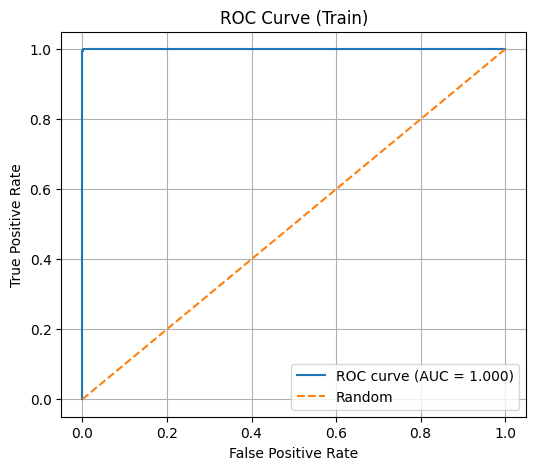

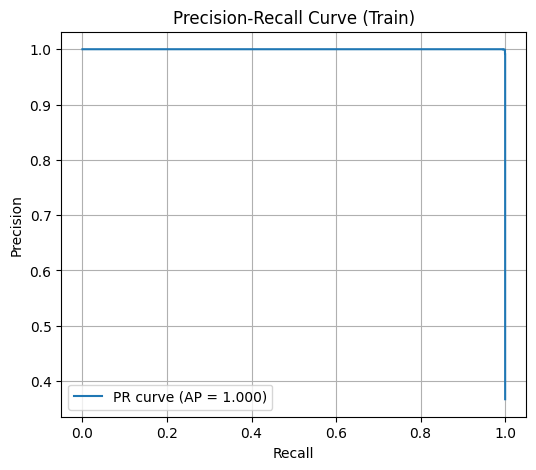

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, proba_train)
roc_auc = roc_auc_score(y_train, proba_train)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Train)")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall curve
precision, recall, thr_pr = precision_recall_curve(y_train, proba_train)
ap = average_precision_score(y_train, proba_train)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Train)")
plt.legend()
plt.grid(True)
plt.show()


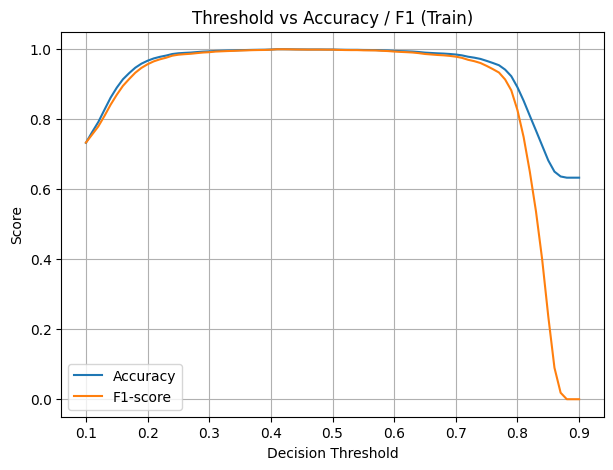

F1 기준 최적 threshold ≈ 0.410


In [10]:
import numpy as np

thresholds = np.linspace(0.1, 0.9, 81)  # 0.1 ~ 0.9, 간격 0.01
acc_list = []
f1_list = []

for thr in thresholds:
    pred_thr = (proba_train >= thr).astype(int)
    acc_list.append(accuracy_score(y_train, pred_thr))
    f1_list.append(f1_score(y_train, pred_thr))

plt.figure(figsize=(7, 5))
plt.plot(thresholds, acc_list, label="Accuracy")
plt.plot(thresholds, f1_list, label="F1-score")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Accuracy / F1 (Train)")
plt.legend()
plt.grid(True)
plt.show()

best_thr_f1 = thresholds[np.argmax(f1_list)]
print(f"F1 기준 최적 threshold ≈ {best_thr_f1:.3f}")


In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# 1) 내부 validation set 불러오기
X_val, y_val = predictor_.load_data_internal(data='val', return_X=True, return_y=True)

# 2) 리더보드에서 모델 이름 가져오기
lb = predictor_.leaderboard(silent=True)   # 내부 validation 기준 leaderboard
models = lb['model'].tolist()              # 모델 이름 리스트
print("모델 목록:", models)

records = []

for m in models:
    # 3) 각 모델별 확률 예측
    proba_val = predictor_.predict_proba(X_val, model=m)

    # AutoGluon 버전에 따라 predict_proba가 DataFrame/ndarray 다를 수 있어서 정리
    if isinstance(proba_val, pd.DataFrame):
        # binary인 경우 보통 0/1 컬럼 → 양성(1) 확률만 사용
        if 1 in proba_val.columns:
            proba_1 = proba_val[1].values
        else:
            proba_1 = proba_val.iloc[:, 1].values
    else:
        # 이미 1차원 ndarray인 경우
        proba_1 = proba_val

    pred_val = (proba_1 >= 0.5).astype(int)

    acc_m = accuracy_score(y_val, pred_val)
    f1_m = f1_score(y_val, pred_val)
    roc_m = roc_auc_score(y_val, proba_1)

    records.append({
        "model": m,
        "accuracy": acc_m,
        "f1": f1_m,
        "roc_auc": roc_m
    })

metrics_df = pd.DataFrame(records).set_index("model")
display(metrics_df.sort_values("f1", ascending=False))



모델 목록: ['LightGBMXT_BAG_L2', 'WeightedEnsemble_L3', 'XGBoost_BAG_L2', 'LightGBM_BAG_L2', 'CatBoost_BAG_L2', 'LightGBMLarge_BAG_L2', 'WeightedEnsemble_L2', 'NeuralNetTorch_BAG_L2', 'NeuralNetFastAI_BAG_L2', 'ExtraTreesGini_BAG_L2', 'RandomForestGini_BAG_L2', 'RandomForestEntr_BAG_L2', 'ExtraTreesEntr_BAG_L2', 'CatBoost_BAG_L1', 'RandomForestGini_BAG_L1', 'LightGBM_BAG_L1', 'NeuralNetFastAI_BAG_L1', 'XGBoost_BAG_L1', 'LightGBMXT_BAG_L1', 'LightGBMLarge_BAG_L1', 'RandomForestEntr_BAG_L1', 'NeuralNetTorch_BAG_L1', 'ExtraTreesEntr_BAG_L1', 'ExtraTreesGini_BAG_L1']


TypeError: data=None is invalid. data must be a pd.DataFrame or str file path to data

In [11]:
pred_y = predictor_.predict(test)

submit = pd.DataFrame()

submit['ID'] = test_df['ID']
submit['label'] = pred_y

submit.to_csv('submitAllFeatureWithWisorWithAllbinning+NewFE2_.csv', index=False)